In [52]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import itertools

import pandas as pd

In [2]:
#mol_path = '/home/llama/thesis/practice/icml18-jtnn/data/tensors/mol'
#tree_path = '/home/llama/thesis/practice/icml18-jtnn/data/tensors/tree'
lat_vecs_path = '/home/llama/thesis/practice/icml18-jtnn/data/tensors3/lat_vecs'
v_paths = glob(lat_vecs_path + '/*')
#m_paths = glob(mol_path + '/*') 
#t_paths = glob(tree_path + '/*')

In [3]:
v_p = []

for i in range(1, 12):
    for x in v_paths:
        if '_' + str(i*5000) + '.' in x:
            v_p.append(x)
            
v_p.append(lat_vecs_path + '/lat_vecs_last.t')

In [4]:
v_p

['/home/llama/thesis/practice/icml18-jtnn/data/tensors3/lat_vecs/lat_vecs_5000.t',
 '/home/llama/thesis/practice/icml18-jtnn/data/tensors3/lat_vecs/lat_vecs_10000.t',
 '/home/llama/thesis/practice/icml18-jtnn/data/tensors3/lat_vecs/lat_vecs_15000.t',
 '/home/llama/thesis/practice/icml18-jtnn/data/tensors3/lat_vecs/lat_vecs_20000.t',
 '/home/llama/thesis/practice/icml18-jtnn/data/tensors3/lat_vecs/lat_vecs_25000.t',
 '/home/llama/thesis/practice/icml18-jtnn/data/tensors3/lat_vecs/lat_vecs_30000.t',
 '/home/llama/thesis/practice/icml18-jtnn/data/tensors3/lat_vecs/lat_vecs_35000.t',
 '/home/llama/thesis/practice/icml18-jtnn/data/tensors3/lat_vecs/lat_vecs_40000.t',
 '/home/llama/thesis/practice/icml18-jtnn/data/tensors3/lat_vecs/lat_vecs_45000.t',
 '/home/llama/thesis/practice/icml18-jtnn/data/tensors3/lat_vecs/lat_vecs_50000.t',
 '/home/llama/thesis/practice/icml18-jtnn/data/tensors3/lat_vecs/lat_vecs_55000.t',
 '/home/llama/thesis/practice/icml18-jtnn/data/tensors3/lat_vecs/lat_vecs_las

In [5]:
tensors = []

In [6]:
for p in v_p:
    tensors.append(torch.load(p))

In [7]:
vec_tensors = list(itertools.chain.from_iterable(tensors))

In [8]:
print(len(vec_tensors)) # + 220

58815


In [9]:
vec_tensors[1]

tensor([[-2.7805e+00, -3.8542e+00,  1.1384e+00, -4.9744e+00,  2.5166e+00,
          1.1117e+00,  2.5993e-01,  1.9900e+00,  1.9476e+00,  5.2223e+00,
         -3.3547e+00, -1.2212e+00,  5.3338e-01,  6.6315e-01, -3.3589e+00,
          3.5495e+00, -5.9496e+00,  2.2113e+00,  5.5004e-01, -6.9140e+00,
          1.6580e+00,  2.3502e+00,  4.1435e-01, -4.6229e-01, -1.0132e+00,
         -5.0367e-01, -5.4610e+00,  4.4774e-01],
        [ 1.0825e+00, -1.4481e-01,  2.4876e-01,  2.4759e-01, -5.6021e+00,
         -2.8223e-01, -3.9661e-02, -1.2759e-01, -7.6635e-02,  5.5345e-02,
          2.1619e-01,  1.2442e-01,  8.2192e-02,  1.9055e-01,  1.1757e-01,
         -6.2958e-04, -6.4740e-01, -6.7896e-02,  1.8789e-01, -3.8665e-02,
         -2.2719e-01,  1.6828e-01,  7.5643e-02, -1.2745e+00, -1.0835e-01,
          1.9851e-01, -4.7007e-02, -1.4272e-01]], requires_grad=True)

In [10]:
lat_vecs = torch.stack(vec_tensors)

In [11]:
lat_vecs.shape

torch.Size([58815, 2, 28])

# Read Vina data

In [12]:
vina_df = pd.read_csv('/home/llama/thesis/practice/icml18-jtnn/data/vina_good_data.csv')
vina_df['idx'] = range(0, len(vina_df))

In [53]:
vina_df.shape

(58815, 2)

# Dataset

In [54]:
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem as Chem

device = torch.device("cuda:0")

from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from scipy.stats import norm, skewnorm, skew, uniform
from scipy.spatial import KDTree

from tqdm.notebook import tqdm

from IPython.display import clear_output

import random

In [15]:
print(lat_vecs.shape)
lvecs = lat_vecs.reshape(lat_vecs.shape[0], 56)
lvecs.shape

torch.Size([58815, 2, 28])


torch.Size([58815, 56])

In [16]:
vina_values = torch.tensor(vina_df["E_vina, kcal/mol"]).float()

In [17]:
vina_values.shape

torch.Size([58815])

In [18]:
lvecs = lvecs.detach()
vina_values = vina_values.detach()

# Sorted dataset

In [19]:
sorted_vina_df = vina_df.sort_values(by='E_vina, kcal/mol')

sorted_idx = list(sorted_vina_df['idx'])
sorted_lvecs = lvecs[sorted_idx]

In [20]:
sorted_vina_values = vina_values[sorted_idx]

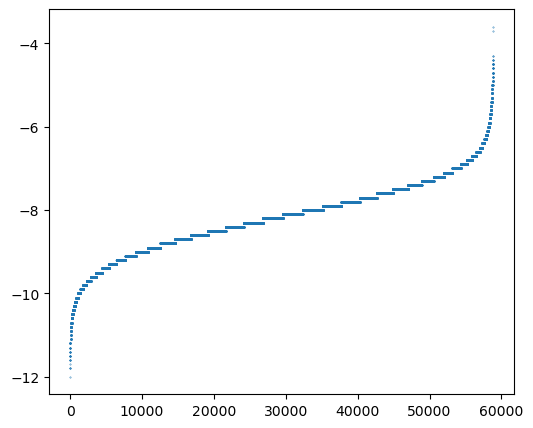

In [21]:
plt.figure(figsize=(6, 5))
plt.scatter(np.arange(sorted_lvecs.shape[0]), sorted_vina_values.numpy(), s=0.1)
#plt.scatter(np.arange(lvecs.shape[0]), vina_values.numpy(), s=0.1)

# GAN1. With splitted train and valid

# С частичным привлечением учителя. Будем использовать именно этот вариант

In [60]:
# prepare training data
train, valid = lvecs[:int(0.8*len(lvecs))], lvecs[int(0.8*len(lvecs)):]
train_vina, valid_vina = vina_values[:int(0.8*len(lvecs))], vina_values[int(0.8*len(lvecs)):]

In [64]:
data = TensorDataset(train, (train_vina < -8.2).float())
dataloader = DataLoader(dataset=data, batch_size=64, shuffle=True, drop_last=True)

In [65]:
next(iter(dataloader))

[tensor([[ 3.7965,  0.1200, -4.9359,  ...,  0.1832, -0.2516, -0.1113],
         [ 1.1605, -1.3825, -9.1160,  ..., -0.2843, -0.0980,  0.1294],
         [-2.7128, -5.2191, -1.9985,  ...,  0.0915,  0.2948,  0.6001],
         ...,
         [ 4.6226, -5.0141,  1.4607,  ...,  0.1537, -0.8563,  0.3784],
         [ 4.6288,  2.1514, -1.5281,  ...,  0.0998, -0.1066,  0.3074],
         [ 1.2882, -0.6280, -4.3035,  ..., -0.4484,  0.2135, -0.0645]]),
 tensor([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
         0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
         1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])]

In [66]:
noise_size = 256
lat_vect_size = 56

In [67]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_size,  512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            
            nn.Linear(512,  1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            
            nn.Linear(1024,  1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            
            nn.Linear(1024,  2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.1),
            
            nn.Linear(2048,  lat_vect_size),
            nn.BatchNorm1d(lat_vect_size),
            nn.LeakyReLU(0.1),
        )
    
    def forward(self, X):
        return self.net(X)

In [68]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fe = nn.Sequential(
            nn.Linear(lat_vect_size, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(512,  256),
            nn.BatchNorm1d(256),
        )
        self.real = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(256,  128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(128,  64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(64, 1),
            nn.Flatten(0),
            nn.Sigmoid(),
        )
        self.clss = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(256,  128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(128,  64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(64, 1),
            nn.Flatten(0),
            nn.Sigmoid(),
        )
    
    def forward(self, X):
        fs =  self.fe(X)
        return self.real(fs), self.clss(fs)

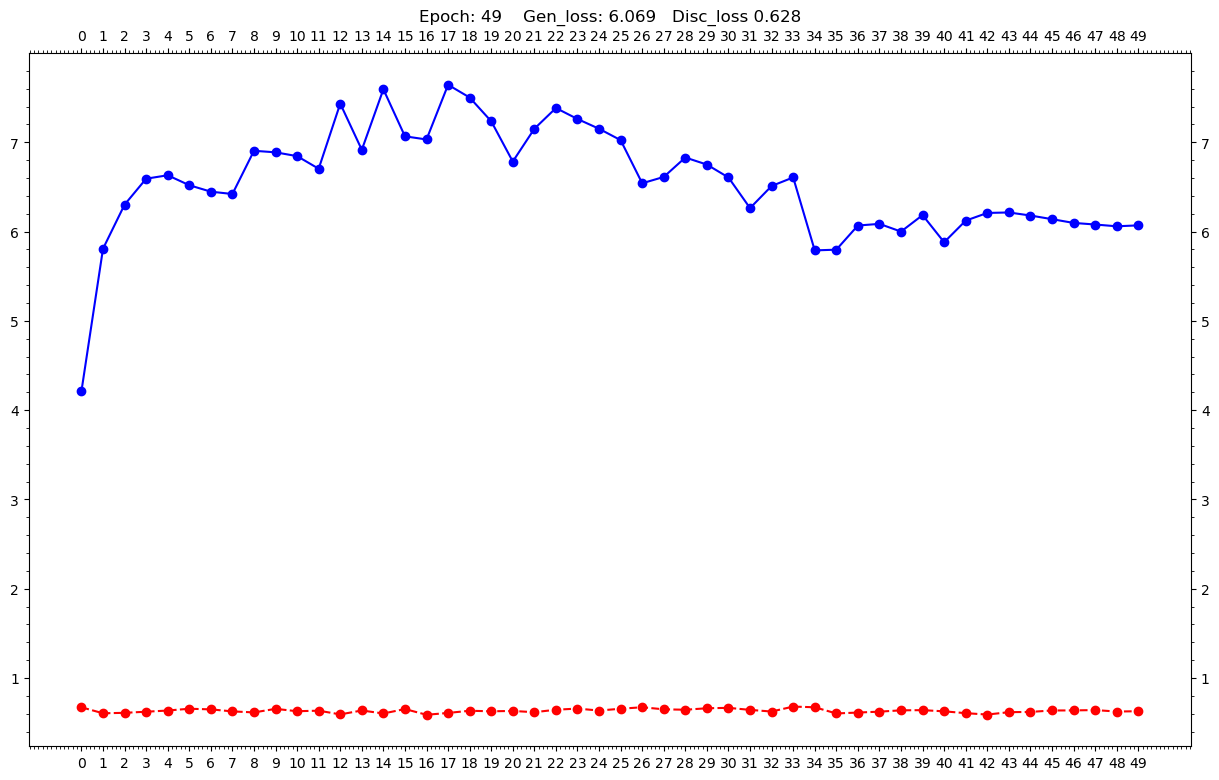

In [69]:
epochs = 50

gen = Generator().to(device)
disc = Discriminator().to(device)
gen_optim = Adam(gen.parameters(), lr=1e-3)
disc_optim = Adam(disc.parameters(), lr=1e-3)
gen_sched = CosineAnnealingLR(gen_optim, epochs)
disc_sched = CosineAnnealingLR(disc_optim, epochs)
rv_n = norm()

gen_prob = 0.8

Lgen = []
Ldisc = []
for ep in range(epochs):
    gen.train()
    disc.train()
    pbar = tqdm(dataloader, desc=f"Train epoch {ep}")
    gen_losses = []
    disc_losses = []
    for X, y in pbar:
        fake_noise = torch.tensor(rv_n.rvs(size=(X.shape[0], noise_size))).float().to(device)
        fake_vectors = gen(fake_noise)
        
        real_vectors = X.float().to(device)
        real_labels = y.float().to(device)
        
        prob, clss = disc(torch.cat([real_vectors, fake_vectors], dim=0))
        real_prob = prob[:real_vectors.shape[0]]
        real_clss = clss[:real_vectors.shape[0]]
        fake_prob = prob[real_vectors.shape[0]:]
        fake_clss = clss[real_vectors.shape[0]:]
        
        if uniform.rvs() < gen_prob:
            loss = 0
            loss += nn.functional.binary_cross_entropy(fake_prob, torch.ones_like(fake_prob)) # на fake мы говорим, что это правильно
            loss += nn.functional.binary_cross_entropy(fake_clss, torch.ones_like(fake_clss)) 
            gen_optim.zero_grad()
            loss.backward()
            gen_optim.step()
            gen_losses.append(loss.item())
        else:
            loss = 0
            loss += nn.functional.binary_cross_entropy(fake_prob, torch.zeros_like(fake_prob)) # здесь мы выдаем правильные вероятности
            loss += nn.functional.binary_cross_entropy(real_prob, torch.ones_like(real_prob))
            loss += nn.functional.binary_cross_entropy(real_clss, real_labels)
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_losses.append(loss.item())

    gen_sched.step()
    disc_sched.step()
    Lgen.append(np.mean(gen_losses))
    Ldisc.append(np.mean(disc_losses))
    
    clear_output()
    plt.figure(figsize=(15, 9))
    plt.tick_params(which="both", top=True, right=True, labeltop=True, labelright=True)
    plt.minorticks_on()
    plt.title(f"Epoch: {ep}    Gen_loss: {Lgen[-1]:.3f}   Disc_loss {Ldisc[-1]:.3f}")
    eps = np.arange(ep + 1)
    plt.xticks(eps)
    plt.plot(eps, Lgen, "bo-")
    plt.plot(eps, Ldisc, "ro-", linestyle='dashed')
    plt.show()

In [70]:
# Save models
torch.save(gen.state_dict(), "./models2/gen_50epoch_gen_prob_0_8.pt")
torch.save(disc.state_dict(), "./models2/disc_50epoch_gen_prob_0_8.pt")

In [71]:
gen.cpu().eval()
disc.cpu().eval()
print()

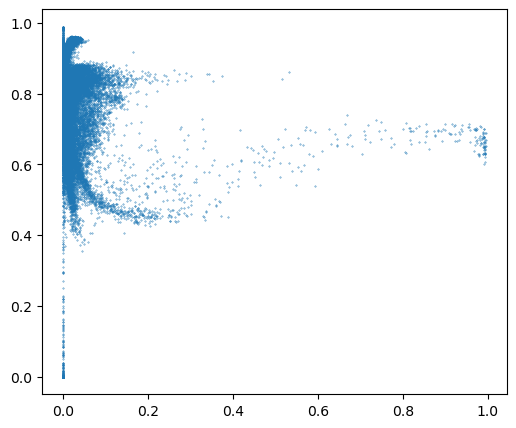

In [72]:
plt.figure(figsize=(6, 5))

rvecs = gen(torch.tensor(rv_n.rvs(size=(sorted_lvecs.shape[0], noise_size))).float())
prob, clss = disc(rvecs)
#plt.xlim(0.1, 0.3)
#plt.ylim(0.8, 1.0)
plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

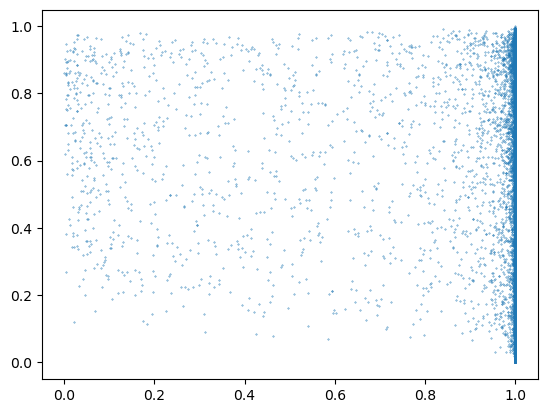

In [73]:
prob, clss = disc(valid)

plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

In [96]:
# Validate model
num_to_gen = 1000

with torch.no_grad():
    gen_vecs = gen(torch.tensor(rv_n.rvs(size=(num_to_gen, noise_size))).float())

In [97]:
torch.save(gen_vecs, './generated_data/gen_vecs_tensor.pt', _use_new_zipfile_serialization=False)

# GAN1

# С частичным привлечением учителя. Будем использовать именно этот вариант

In [56]:
# prepare training data

torch.Size([58815, 56])

In [74]:
data = TensorDataset(lvecs, (vina_values < -8.2).float())
dataloader = DataLoader(dataset=data, batch_size=64, shuffle=True, drop_last=True)

In [75]:
next(iter(dataloader))

[tensor([[ 5.8592,  1.2334, -2.3254,  ..., -0.3677,  0.0735,  0.2378],
         [ 1.5267,  2.8122, -2.8832,  ..., -0.1423, -0.3574,  0.0745],
         [ 1.6781, -1.1304,  1.6211,  ...,  0.1024,  0.3680,  0.8502],
         ...,
         [-3.8727, -2.0823, -4.4724,  ...,  0.2334, -0.2021,  0.2042],
         [ 4.9498, -1.9295, -4.1870,  ..., -0.5802, -0.0545,  0.0944],
         [-0.2486,  5.9382, -5.1397,  ..., -0.0432,  0.3822,  0.3825]]),
 tensor([1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
         1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
         1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
         0., 1., 1., 1., 1., 1., 1., 0., 1., 1.])]

In [76]:
noise_size = 256
lat_vect_size = 56

In [77]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_size,  512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            
            nn.Linear(512,  1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            
            nn.Linear(1024,  1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            
            nn.Linear(1024,  2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.1),
            
            nn.Linear(2048,  lat_vect_size),
            nn.BatchNorm1d(lat_vect_size),
            nn.LeakyReLU(0.1),
        )
    
    def forward(self, X):
        return self.net(X)

In [78]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fe = nn.Sequential(
            nn.Linear(lat_vect_size, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(512,  256),
            nn.BatchNorm1d(256),
        )
        self.real = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(256,  128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(128,  64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(64, 1),
            nn.Flatten(0),
            nn.Sigmoid(),
        )
        self.clss = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(256,  128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(128,  64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(64, 1),
            nn.Flatten(0),
            nn.Sigmoid(),
        )
    
    def forward(self, X):
        fs =  self.fe(X)
        return self.real(fs), self.clss(fs)

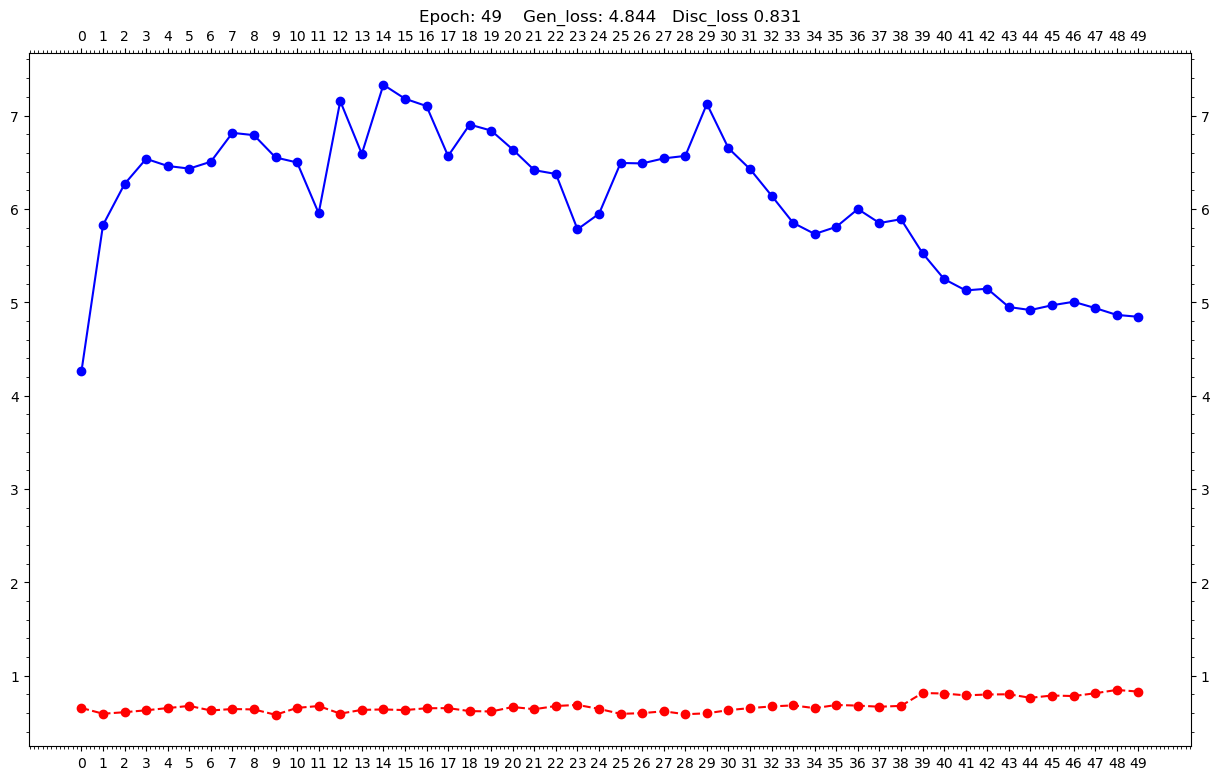

In [30]:
epochs = 50

gen = Generator().to(device)
disc = Discriminator().to(device)
gen_optim = Adam(gen.parameters(), lr=1e-3)
disc_optim = Adam(disc.parameters(), lr=1e-3)
gen_sched = CosineAnnealingLR(gen_optim, epochs)
disc_sched = CosineAnnealingLR(disc_optim, epochs)
rv_n = norm()

gen_prob = 0.8

Lgen = []
Ldisc = []
for ep in range(epochs):
    gen.train()
    disc.train()
    pbar = tqdm(dataloader, desc=f"Train epoch {ep}")
    gen_losses = []
    disc_losses = []
    for X, y in pbar:
        fake_noise = torch.tensor(rv_n.rvs(size=(X.shape[0], noise_size))).float().to(device)
        fake_vectors = gen(fake_noise)
        
        real_vectors = X.float().to(device)
        real_labels = y.float().to(device)
        
        prob, clss = disc(torch.cat([real_vectors, fake_vectors], dim=0))
        real_prob = prob[:real_vectors.shape[0]]
        real_clss = clss[:real_vectors.shape[0]]
        fake_prob = prob[real_vectors.shape[0]:]
        fake_clss = clss[real_vectors.shape[0]:]
        
        if uniform.rvs() < gen_prob:
            loss = 0
            loss += nn.functional.binary_cross_entropy(fake_prob, torch.ones_like(fake_prob)) # на fake мы говорим, что это правильно
            loss += nn.functional.binary_cross_entropy(fake_clss, torch.ones_like(fake_clss)) 
            gen_optim.zero_grad()
            loss.backward()
            gen_optim.step()
            gen_losses.append(loss.item())
        else:
            loss = 0
            loss += nn.functional.binary_cross_entropy(fake_prob, torch.zeros_like(fake_prob)) # здесь мы выдаем правильные вероятности
            loss += nn.functional.binary_cross_entropy(real_prob, torch.ones_like(real_prob))
            loss += nn.functional.binary_cross_entropy(real_clss, real_labels)
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_losses.append(loss.item())

    gen_sched.step()
    disc_sched.step()
    Lgen.append(np.mean(gen_losses))
    Ldisc.append(np.mean(disc_losses))
    
    clear_output()
    plt.figure(figsize=(15, 9))
    plt.tick_params(which="both", top=True, right=True, labeltop=True, labelright=True)
    plt.minorticks_on()
    plt.title(f"Epoch: {ep}    Gen_loss: {Lgen[-1]:.3f}   Disc_loss {Ldisc[-1]:.3f}")
    eps = np.arange(ep + 1)
    plt.xticks(eps)
    plt.plot(eps, Lgen, "bo-")
    plt.plot(eps, Ldisc, "ro-", linestyle='dashed')
    plt.show()

In [31]:
# Save models
torch.save(gen.state_dict(), "./models/gen_50epoch_gen_prob_0_8.pt")
torch.save(disc.state_dict(), "./models/disc_50epoch_gen_prob_0_8.pt")

In [36]:
gen.cpu().eval()
disc.cpu().eval()
print()

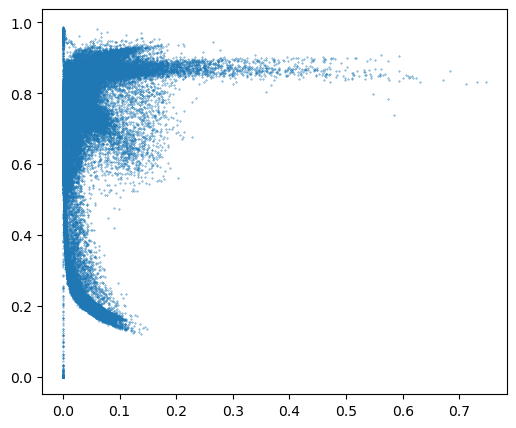

In [37]:
plt.figure(figsize=(6, 5))

rvecs = gen(torch.tensor(rv_n.rvs(size=(sorted_lvecs.shape[0], noise_size))).float())
prob, clss = disc(rvecs)
#plt.xlim(0.1, 0.3)
#plt.ylim(0.8, 1.0)
plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

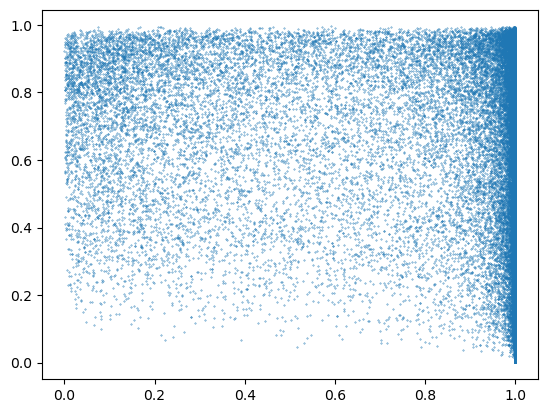

In [38]:
prob, clss = disc(sorted_lvecs)

plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

In [96]:
# Validate model
num_to_gen = 1000

with torch.no_grad():
    gen_vecs = gen(torch.tensor(rv_n.rvs(size=(num_to_gen, noise_size))).float())

In [97]:
torch.save(gen_vecs, './generated_data/gen_vecs_tensor.pt', _use_new_zipfile_serialization=False)

# GAN2

In [41]:
noise_size = 256
lat_vect_size = 56

In [42]:
class Generator2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_size,  512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            
            nn.Linear(512,  1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            
            nn.Linear(1024,  2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.1),
            
            nn.Linear(2048,  1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            
            nn.Linear(1024,  512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            
            nn.Linear(512,  lat_vect_size),
            nn.BatchNorm1d(lat_vect_size),
            nn.LeakyReLU(0.1),
        )
    
    def forward(self, X):
        return self.net(X)

In [43]:
class Discriminator2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fe = nn.Sequential(
            nn.Linear(lat_vect_size, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(512,  256),
            nn.BatchNorm1d(256),
        )
        self.real = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(256,  128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(128,  64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(64, 1),
            nn.Flatten(0),
            nn.Sigmoid(),
        )
        self.clss = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(256,  128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(128,  64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(64, 1),
            nn.Flatten(0),
            nn.Sigmoid(),
        )
    
    def forward(self, X):
        fs =  self.fe(X)
        return self.real(fs), self.clss(fs)

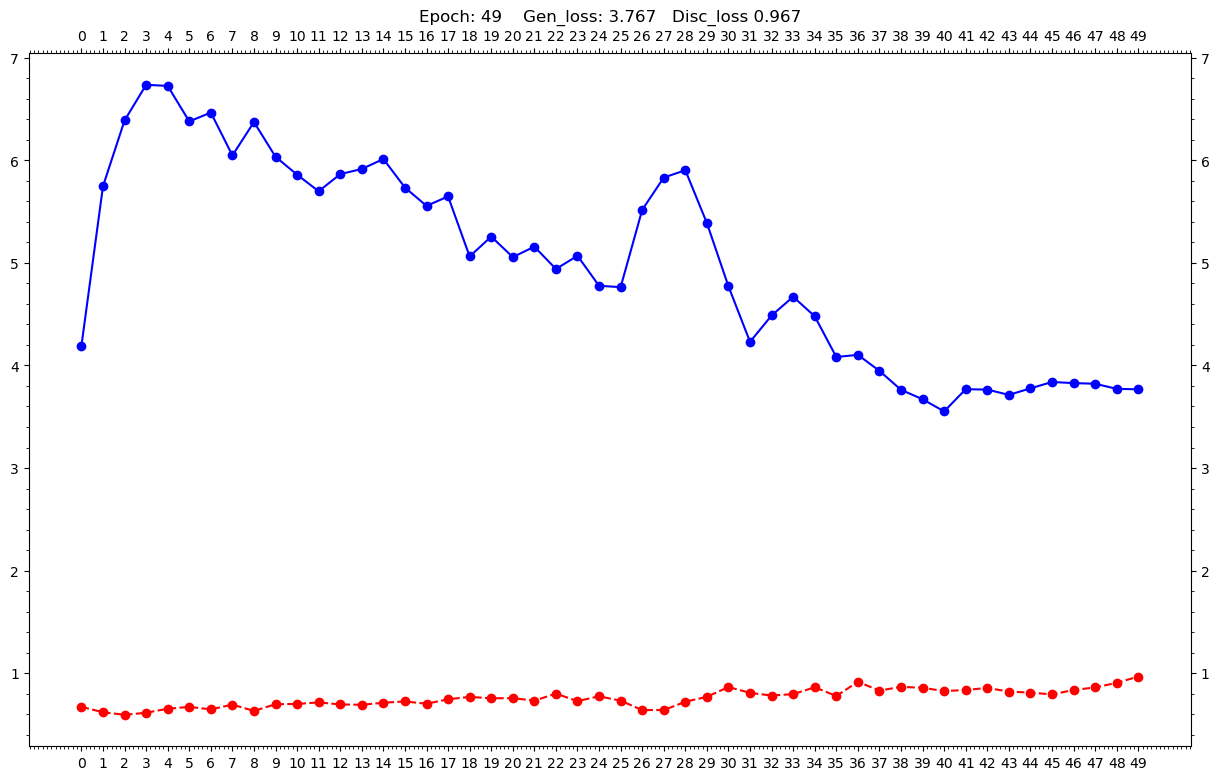

In [44]:
epochs = 50

gen = Generator2().to(device)
disc = Discriminator().to(device)
gen_optim = Adam(gen.parameters(), lr=1e-3)
disc_optim = Adam(disc.parameters(), lr=1e-3)
gen_sched = CosineAnnealingLR(gen_optim, epochs)
disc_sched = CosineAnnealingLR(disc_optim, epochs)
rv_n = norm()

gen_prob = 0.8

Lgen = []
Ldisc = []
for ep in range(epochs):
    gen.train()
    disc.train()
    pbar = tqdm(dataloader, desc=f"Train epoch {ep}")
    gen_losses = []
    disc_losses = []
    for X, y in pbar:
        fake_noise = torch.tensor(rv_n.rvs(size=(X.shape[0], noise_size))).float().to(device)
        fake_vectors = gen(fake_noise)
        
        real_vectors = X.float().to(device)
        real_labels = y.float().to(device)
        
        prob, clss = disc(torch.cat([real_vectors, fake_vectors], dim=0))
        real_prob = prob[:real_vectors.shape[0]]
        real_clss = clss[:real_vectors.shape[0]]
        fake_prob = prob[real_vectors.shape[0]:]
        fake_clss = clss[real_vectors.shape[0]:]
        
        if uniform.rvs() < gen_prob:
            loss = 0
            loss += nn.functional.binary_cross_entropy(fake_prob, torch.ones_like(fake_prob)) # на fake мы говорим, что это правильно
            loss += nn.functional.binary_cross_entropy(fake_clss, torch.ones_like(fake_clss)) 
            gen_optim.zero_grad()
            loss.backward()
            gen_optim.step()
            gen_losses.append(loss.item())
        else:
            loss = 0
            loss += nn.functional.binary_cross_entropy(fake_prob, torch.zeros_like(fake_prob)) # здесь мы выдаем правильные вероятности
            loss += nn.functional.binary_cross_entropy(real_prob, torch.ones_like(real_prob))
            loss += nn.functional.binary_cross_entropy(real_clss, real_labels)
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_losses.append(loss.item())

    gen_sched.step()
    disc_sched.step()
    Lgen.append(np.mean(gen_losses))
    Ldisc.append(np.mean(disc_losses))
    
    clear_output()
    plt.figure(figsize=(15, 9))
    plt.tick_params(which="both", top=True, right=True, labeltop=True, labelright=True)
    plt.minorticks_on()
    plt.title(f"Epoch: {ep}    Gen_loss: {Lgen[-1]:.3f}   Disc_loss {Ldisc[-1]:.3f}")
    eps = np.arange(ep + 1)
    plt.xticks(eps)
    plt.plot(eps, Lgen, "bo-")
    plt.plot(eps, Ldisc, "ro-", linestyle='dashed')
    plt.show()
    plt.show()

In [45]:
# Save models
torch.save(gen.state_dict(), "./models/gen2_50epoch_gen_prob_0_8.pt")
torch.save(disc.state_dict(), "./models/disc2_50epoch_gen_prob_0_8.pt")

In [46]:
gen.cpu().eval()
disc.cpu().eval()
print()

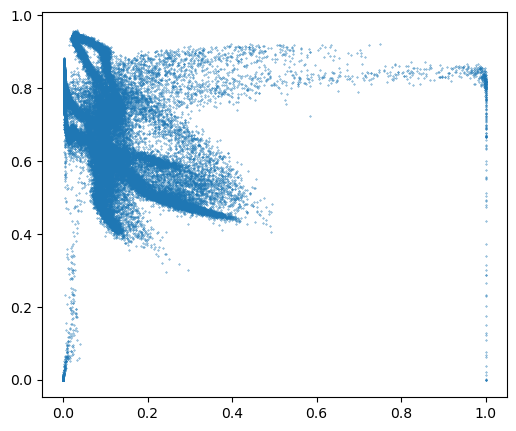

In [47]:
plt.figure(figsize=(6, 5))

rvecs = gen(torch.tensor(rv_n.rvs(size=(sorted_lvecs.shape[0], noise_size))).float())
prob, clss = disc(rvecs)
#plt.xlim(0.1, 0.3)
#plt.ylim(0.8, 1.0)
plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

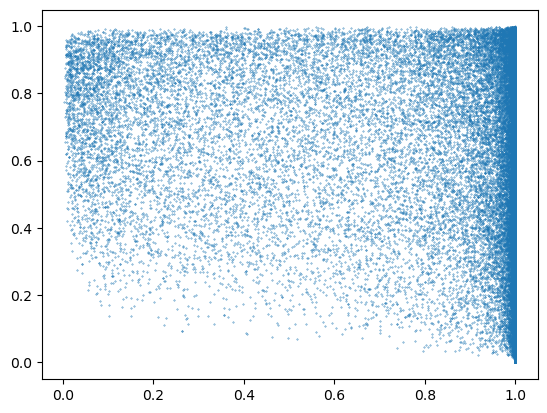

In [48]:
prob, clss = disc(lvecs)
plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

In [96]:
# Validate model
num_to_gen = 1000

with torch.no_grad():
    gen_vecs = gen(torch.tensor(rv_n.rvs(size=(num_to_gen, noise_size))).float())

In [97]:
torch.save(gen_vecs, './generated_data/gen_vecs_tensor.pt', _use_new_zipfile_serialization=False)

# GAN3

In [49]:
noise_size = 256
lat_vect_size = 56

In [50]:
class Generator3(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_size,  512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            
            nn.Linear(512,  1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            
            nn.Linear(1024,  1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            
            nn.Linear(1024,  2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.1),
            
            nn.Linear(2048,  1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            
            nn.Linear(1024,  512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            
            nn.Linear(512,  lat_vect_size),
            nn.BatchNorm1d(lat_vect_size),
            nn.LeakyReLU(0.1),
        )
    
    def forward(self, X):
        return self.net(X)

In [51]:
class Discriminator3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fe = nn.Sequential(
            nn.Linear(lat_vect_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(512,  256),
            nn.BatchNorm1d(256),
        )
        self.real = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(256,  128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(128,  64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(64, 1),
            nn.Flatten(0),
            nn.Sigmoid(),
        )
        self.clss = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(256,  128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(128,  64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Linear(64, 1),
            nn.Flatten(0),
            nn.Sigmoid(),
        )
    
    def forward(self, X):
        fs =  self.fe(X)
        return self.real(fs), self.clss(fs)

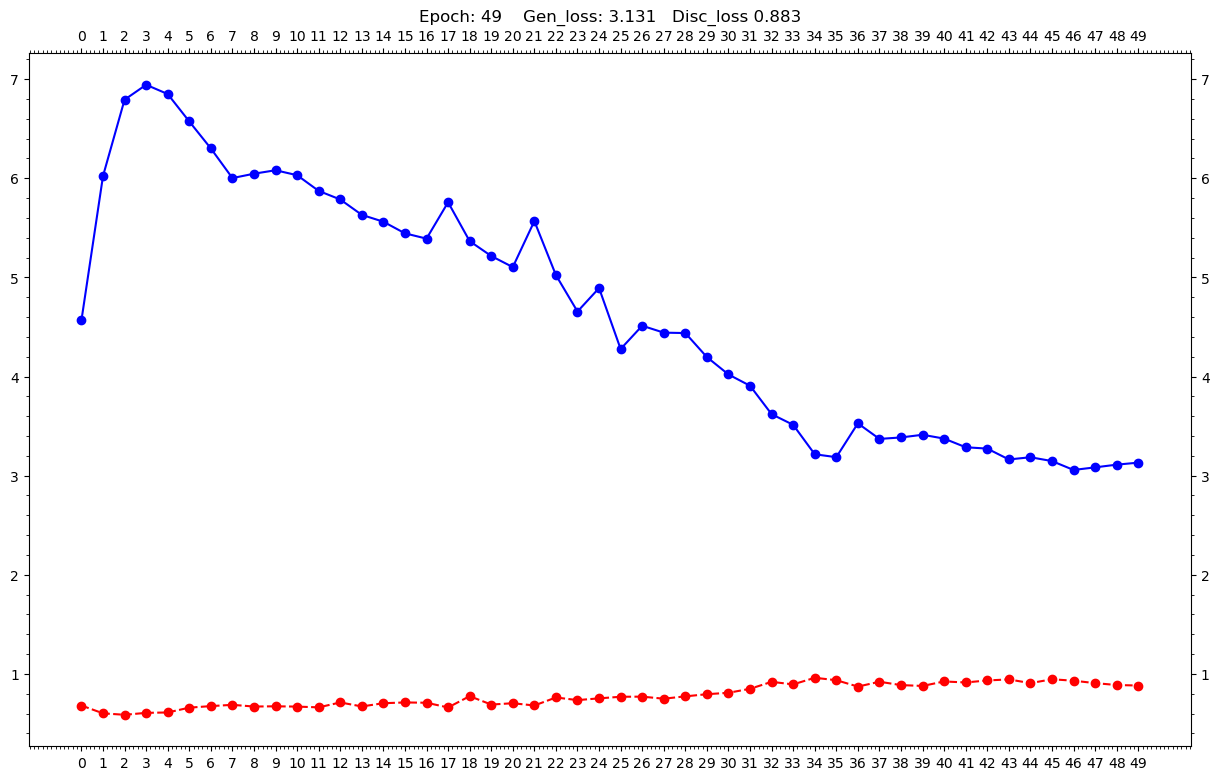

In [53]:
epochs = 50

gen = Generator3().to(device)
disc = Discriminator3().to(device)
gen_optim = Adam(gen.parameters(), lr=1e-3)
disc_optim = Adam(disc.parameters(), lr=1e-3)
gen_sched = CosineAnnealingLR(gen_optim, epochs)
disc_sched = CosineAnnealingLR(disc_optim, epochs)
rv_n = norm()

gen_prob = 0.8

Lgen = []
Ldisc = []
for ep in range(epochs):
    gen.train()
    disc.train()
    pbar = tqdm(dataloader, desc=f"Train epoch {ep}")
    gen_losses = []
    disc_losses = []
    for X, y in pbar:
        fake_noise = torch.tensor(rv_n.rvs(size=(X.shape[0], noise_size))).float().to(device)
        fake_vectors = gen(fake_noise)
        
        real_vectors = X.float().to(device)
        real_labels = y.float().to(device)
        
        prob, clss = disc(torch.cat([real_vectors, fake_vectors], dim=0))
        real_prob = prob[:real_vectors.shape[0]]
        real_clss = clss[:real_vectors.shape[0]]
        fake_prob = prob[real_vectors.shape[0]:]
        fake_clss = clss[real_vectors.shape[0]:]
        
        if uniform.rvs() < gen_prob:
            loss = 0
            loss += nn.functional.binary_cross_entropy(fake_prob, torch.ones_like(fake_prob)) # на fake мы говорим, что это правильно
            loss += nn.functional.binary_cross_entropy(fake_clss, torch.ones_like(fake_clss)) 
            gen_optim.zero_grad()
            loss.backward()
            gen_optim.step()
            gen_losses.append(loss.item())
        else:
            loss = 0
            loss += nn.functional.binary_cross_entropy(fake_prob, torch.zeros_like(fake_prob)) # здесь мы выдаем правильные вероятности
            loss += nn.functional.binary_cross_entropy(real_prob, torch.ones_like(real_prob))
            loss += nn.functional.binary_cross_entropy(real_clss, real_labels)
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_losses.append(loss.item())

    gen_sched.step()
    disc_sched.step()
    Lgen.append(np.mean(gen_losses))
    Ldisc.append(np.mean(disc_losses))
    
    clear_output()
    plt.figure(figsize=(15, 9))
    
    plt.tick_params(which="both", top=True, right=True, labeltop=True, labelright=True)
    plt.minorticks_on()
    plt.title(f"Epoch: {ep}    Gen_loss: {Lgen[-1]:.3f}   Disc_loss {Ldisc[-1]:.3f}")
    eps = np.arange(ep + 1)
    plt.xticks(eps)
    plt.plot(eps, Lgen, "bo-")
    plt.plot(eps, Ldisc, "ro-", linestyle='dashed')
    plt.show()

In [54]:
# Save models
torch.save(gen.state_dict(), "./models/gen3_50epoch_gen_prob_0_8.pt")
torch.save(disc.state_dict(), "./models/disc3_50epoch_gen_prob_0_8.pt")

In [55]:
gen.cpu().eval()
disc.cpu().eval()
print()

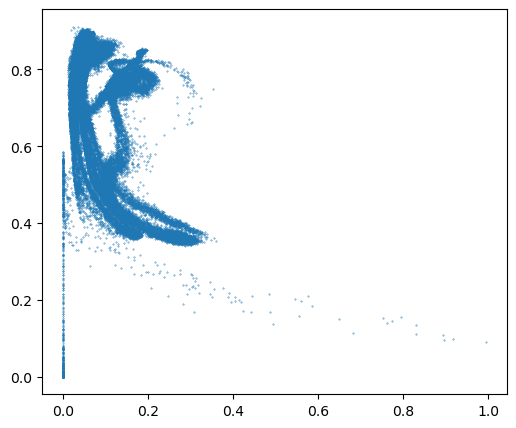

In [56]:
plt.figure(figsize=(6, 5))

rvecs = gen(torch.tensor(rv_n.rvs(size=(sorted_lvecs.shape[0], noise_size))).float())
prob, clss = disc(rvecs)
#plt.xlim(0.1, 0.3)
#plt.ylim(0.8, 1.0)
plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

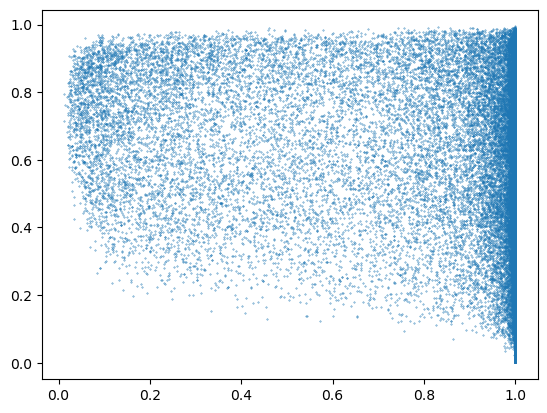

In [57]:
prob, clss = disc(lvecs)

plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

# Generation

## GAN

In [79]:
gen = Generator()
gen.eval()
gen.load_state_dict(torch.load("./models/gen_50epoch_gen_prob_0_8.pt"))
disc = Discriminator()
disc.eval()
disc.load_state_dict(torch.load("./models/disc_50epoch_gen_prob_0_8.pt"))

<All keys matched successfully>

In [80]:
rv_n = norm() # A normal continuous random variable.

In [83]:
disc

Discriminator(
  (fe): Sequential(
    (0): Linear(in_features=56, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (real): Sequential(
    (0): LeakyReLU(negative_slope=0.1)
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1)
    (9): Dropout(p=0.1, inplace=False)
    (10): Linear(in_fe

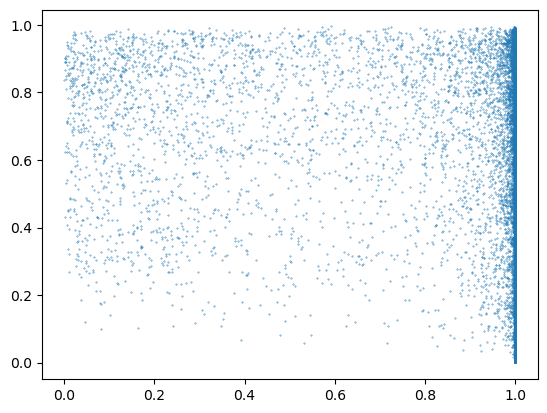

In [81]:
prob, clss = disc(valid)

plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

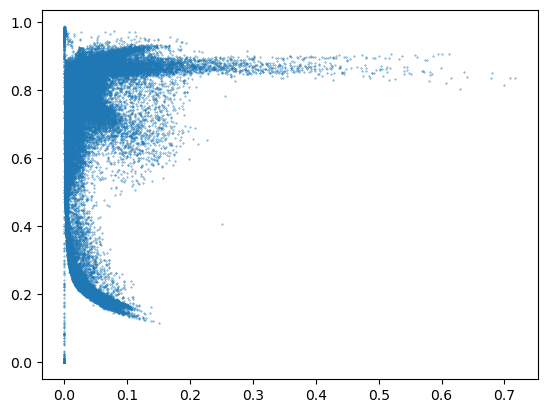

In [49]:
rvecs = gen(torch.tensor(rv_n.rvs(size=(50000, noise_size))).float())
prob, clss = disc(rvecs)

plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

In [46]:
#rvecs = rvecs[(prob > 0.15) & (clss > 0.8)].detach()
#rvecs.shape

torch.Size([1395, 56])

In [47]:
#torch.save(rvecs, './generated_data/gen1_vecs_tensor.pt', _use_new_zipfile_serialization=False)

# Select mols with low probability of good results

In [50]:
rvecs = rvecs[(prob < 0.15) & (clss < 0.3)].detach()
rvecs.shape

torch.Size([9413, 56])

In [51]:
torch.save(rvecs, './generated_data/gen1_vecs_low_prob_tensor.pt', _use_new_zipfile_serialization=False)

In [113]:
gen

Generator(
  (net): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1)
    (9): Linear(in_features=1024, out_features=2048, bias=True)
    (10): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.1)
    (12): Linear(in_features=2048, out_features=56, bias=True)
    (13): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.1)
 

# GAN2

In [64]:
gen2 = Generator2()
gen2.eval()
gen2.load_state_dict(torch.load("./models/gen2_50epoch_gen_prob_0_8.pt"))
disc2 = Discriminator2()
disc2.eval()
disc2.load_state_dict(torch.load("./models/disc2_50epoch_gen_prob_0_8.pt"))

<All keys matched successfully>

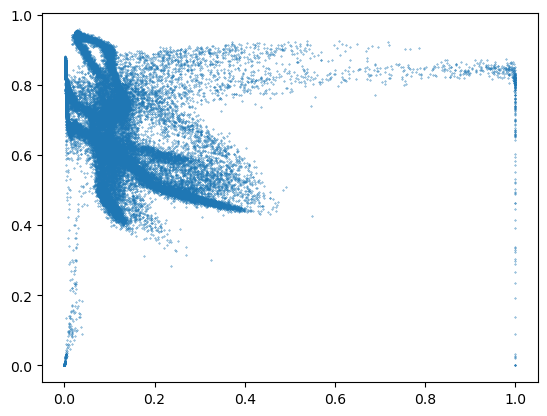

In [95]:
rvecs2 = gen2(torch.tensor(rv_n.rvs(size=(50000, noise_size))).float())
prob, clss = disc2(rvecs2)

plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

In [96]:
rvecs2 = rvecs2[(prob > 0.2) & (clss > 0.8)].detach()
rvecs2.shape

torch.Size([1176, 56])

In [98]:
torch.save(rvecs2, './generated_data/gen2_vecs_tensor.pt', _use_new_zipfile_serialization=False)

# GAN3

In [66]:
gen3 = Generator3()
gen3.eval()
gen3.load_state_dict(torch.load("./models/gen3_50epoch_gen_prob_0_8.pt"))
disc3 = Discriminator3()
disc3.eval()
disc3.load_state_dict(torch.load("./models/disc3_50epoch_gen_prob_0_8.pt"))

<All keys matched successfully>

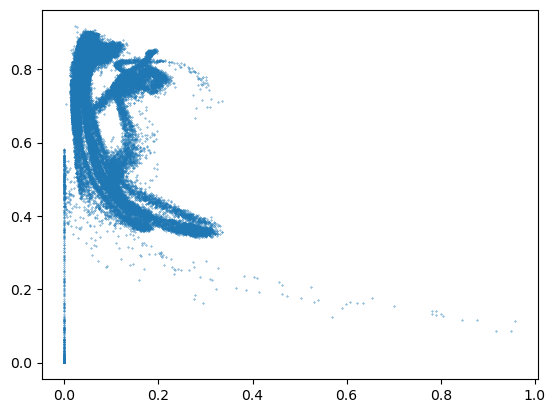

In [105]:
rvecs3 = gen3(torch.tensor(rv_n.rvs(size=(50000, noise_size))).float())
prob, clss = disc3(rvecs3)

plt.scatter(prob.detach().numpy(), clss.detach().numpy(), s=0.1)

In [106]:
rvecs3 = rvecs3[(prob > 0.15) & (clss > 0.8)].detach()
rvecs3.shape

torch.Size([997, 56])

In [107]:
torch.save(rvecs3, './generated_data/gen3_vecs_tensor.pt', _use_new_zipfile_serialization=False)

# ------------- End -------------- 